# Add new data

## **Prepare Environment**

<br/>

### Imports

In [336]:
# Data analysis and data wrangling
import numpy as np
import pandas as pd

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

# Preprocessing
from sklearn.preprocessing import MinMaxScaler

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# deep learning
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Other
from IPython.display import Image
from time import time
import configparser
import subprocess
import warnings
import pprint
import os

# custom functions
import sys
sys.path.append('../src')  # Add the 'src' directory to the Python path

from utils import (
    path_to_work,
    plot_box_plot,
    save_image,
    save_dataframe,
    test_stationary,
    show_result_model,
)

ImportError: cannot import name 'create_bag_of_words' from 'utils' (/Users/bruno.campos/projects/forecast-of-time-series-with-stock-data/notebooks/../src/utils.py)

### Prepare Principal Directory

In [308]:
path_to_work('notebooks')

'Current working directory: /Users/bruno.campos/projects/forecast-of-time-series-with-stock-data'

<br/>

### Set Config

In [309]:
# Visualization inside the jupyter
%matplotlib inline

# Load the "autoreload" extension so that code can change
%load_ext autoreload

# ----------
# Plot
# ----------
# graph style
sns.set_style("darkgrid")
plt.style.use('fivethirtyeight')

# ----------
# Seaborn rcParams
# ----------
rc={'savefig.dpi': 500,
    'figure.autolayout': True,
    'figure.figsize': [17, 12],
    'axes.labelsize': 18,
    'axes.titlesize': 18,
    'font.size': 10,
    'lines.linewidth': 1.0,
    'lines.markersize': 8,
    'legend.fontsize': 15,
    'xtick.labelsize': 15,
    'ytick.labelsize': 15}

sns.set(context='notebook',  # notebook
        style='darkgrid',
        palette='deep',
        color_codes=True,
        rc=rc)

# ----------
# Pandas
# ----------
# Floating point
pd.options.display.float_format = '{:.2f}'.format

# Print xxxx rows and all columns
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', None)

# ----------
# Python
# ----------
# pretty print
pp = pprint.PrettyPrinter(indent=4)

# Supress unnecessary warnings so that presentation looks clean
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [310]:
# Seaborn rcParams
# ===================
sns.set(context='poster',  # notebook
        style='darkgrid',
        palette='deep',
        color_codes=True)

plt.style.use('fivethirtyeight')

<br/>

### Load Data

In [311]:
%%time
df = pd.read_csv('data/raw/ibov_04-2024.csv', encoding='utf8', delimiter=',', parse_dates=True, index_col=0, verbose=True)
print(df.info())
df.head()

Tokenization took: 0.44 ms
Type conversion took: 1.24 ms
Parser memory cleanup took: 0.00 ms
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1571 entries, 2018-01-02 16:56:00 to 2024-05-03 16:56:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    1571 non-null   float64
 1   close   1571 non-null   float64
 2   high    1571 non-null   float64
 3   low     1571 non-null   float64
dtypes: float64(4)
memory usage: 61.4 KB
None
CPU times: user 14.1 ms, sys: 3.27 ms, total: 17.3 ms
Wall time: 15.7 ms


,open,close,high,low
date,,,,
2018-01-02 16:56:00,76402.60,77891.04,77909.01,76402.60
2018-01-03 16:56:00,77889.41,77995.16,78413.89,77601.52
2018-01-04 16:56:00,77997.69,78647.42,79134.83,77997.69
2018-01-05 16:56:00,78644.27,79071.47,79071.47,78218.11
2018-01-08 16:56:00,79070.27,79378.54,79395.45,78631.25


## Split Data

In [312]:
size_train = round(1571*0.962)
size_test = round(1571*0.038)
df_train = df.iloc[:size_train]
df_test = df.iloc[size_train:]

print(f'Total training = {size_train}')
print(f'Total testing = {size_test}')

Total training = 1511
Total testing = 60


Text(0.5, 1.0, 'Train size: 1511')

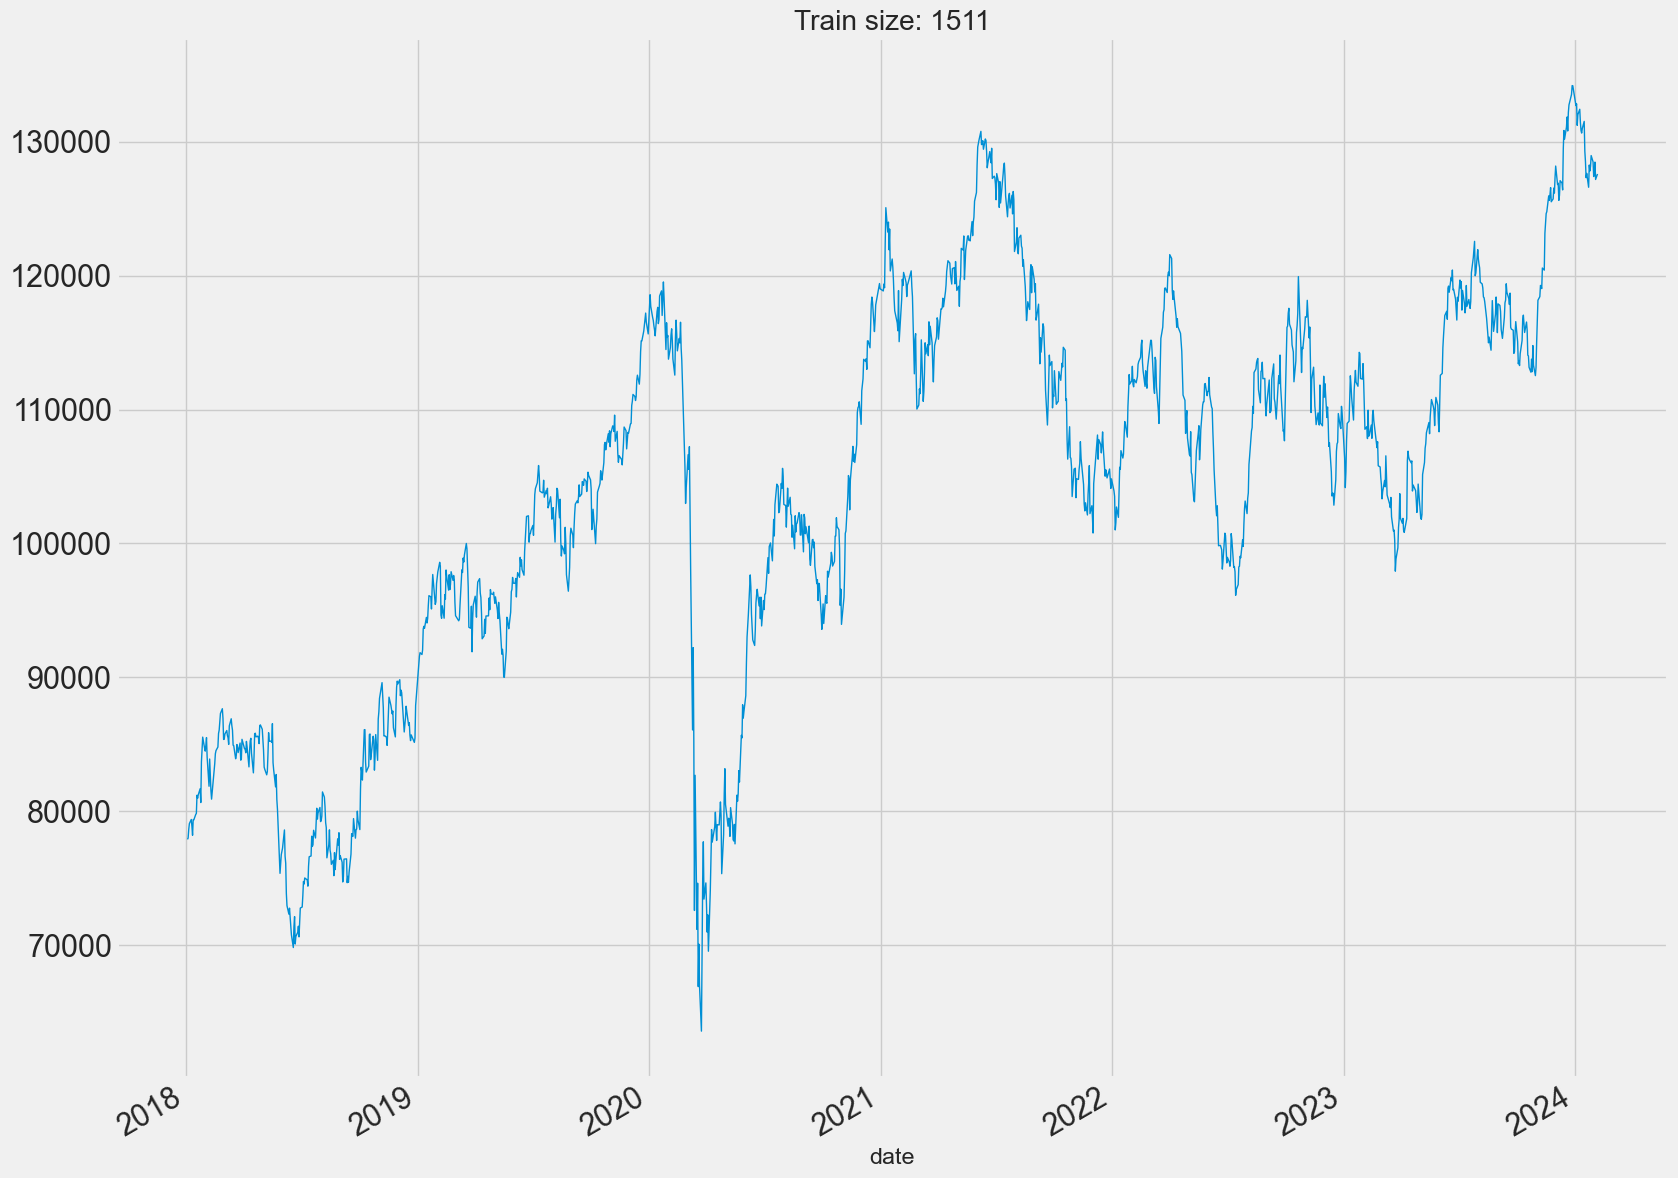

In [313]:
df_train['close'].plot(linewidth=1)
plt.grid(True)
plt.title(f'Train size: {len(df_train)}')

Text(0.5, 1.0, 'Test size: 60')

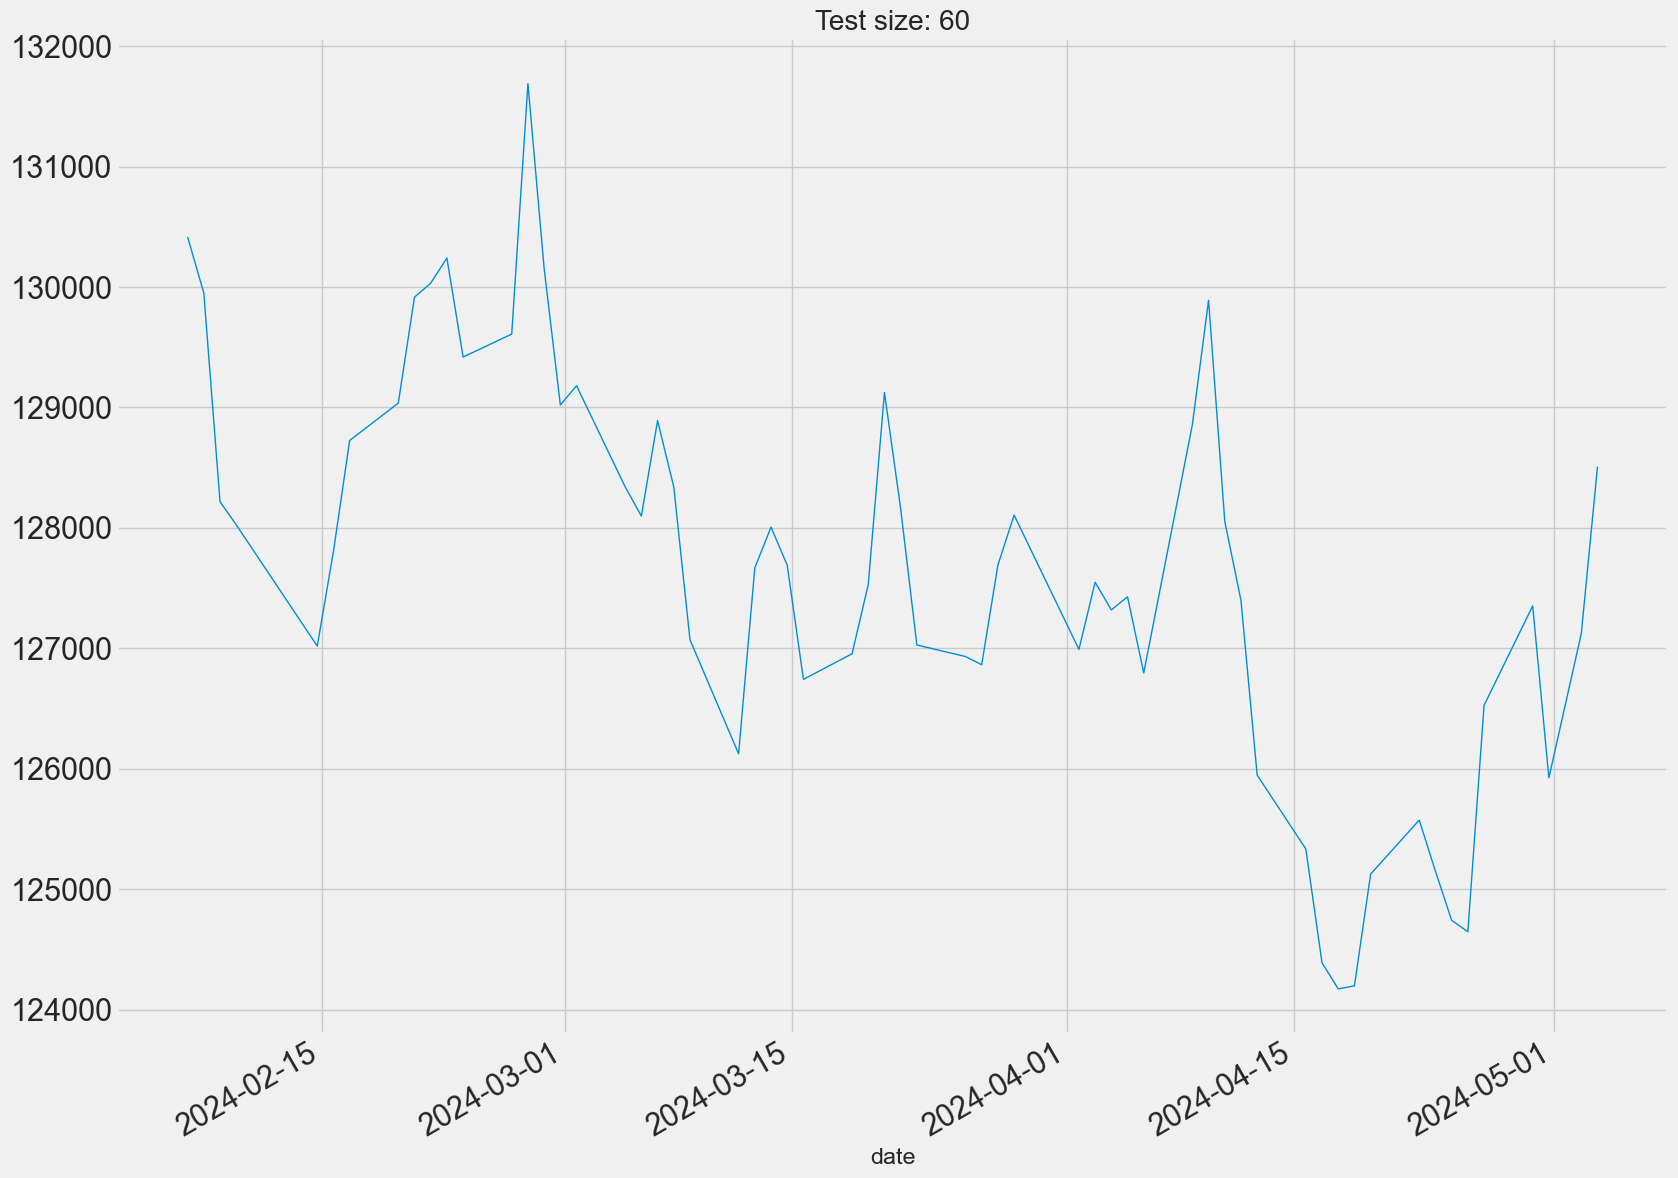

In [314]:
df_test['close'].plot(linewidth=1)
plt.grid(True)
plt.title(f'Test size: {len(df_test)}')

In [315]:
df_train.index

DatetimeIndex(['2018-01-02 16:56:00', '2018-01-03 16:56:00',
               '2018-01-04 16:56:00', '2018-01-05 16:56:00',
               '2018-01-08 16:56:00', '2018-01-09 16:56:00',
               '2018-01-10 16:56:00', '2018-01-11 16:56:00',
               '2018-01-12 16:56:00', '2018-01-15 16:56:00',
               ...
               '2024-01-23 16:56:00', '2024-01-24 16:56:00',
               '2024-01-25 16:56:00', '2024-01-26 16:56:00',
               '2024-01-29 16:56:00', '2024-01-30 16:56:00',
               '2024-01-31 16:56:00', '2024-02-01 16:56:00',
               '2024-02-02 16:56:00', '2024-02-05 16:56:00'],
              dtype='datetime64[ns]', name='date', length=1511, freq=None)

In [316]:
df_test.index

DatetimeIndex(['2024-02-06 16:56:00', '2024-02-07 16:56:00',
               '2024-02-08 16:56:00', '2024-02-09 16:56:00',
               '2024-02-14 16:56:00', '2024-02-15 16:56:00',
               '2024-02-16 16:56:00', '2024-02-19 16:56:00',
               '2024-02-20 16:56:00', '2024-02-21 16:56:00',
               '2024-02-22 16:56:00', '2024-02-23 16:56:00',
               '2024-02-26 16:56:00', '2024-02-27 16:56:00',
               '2024-02-28 16:56:00', '2024-02-29 16:56:00',
               '2024-03-01 16:56:00', '2024-03-04 16:56:00',
               '2024-03-05 16:56:00', '2024-03-06 16:56:00',
               '2024-03-07 16:56:00', '2024-03-08 16:56:00',
               '2024-03-11 16:56:00', '2024-03-12 16:56:00',
               '2024-03-13 16:56:00', '2024-03-14 16:56:00',
               '2024-03-15 16:56:00', '2024-03-18 16:56:00',
               '2024-03-19 16:56:00', '2024-03-20 16:56:00',
               '2024-03-21 16:56:00', '2024-03-22 16:56:00',
               '2024-03-

## Modeling

In [317]:
train_max = df_train.max()
train_min = df_train.min()

train = (df_train - train_min)/(train_max - train_min)
test = (df_test - train_min)/(train_max - train_min)

In [318]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []

    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])

    return np.array(Xs).astype('float32'), np.array(ys).astype('float32')

In [319]:
time_steps = 1

X_train, y_train = create_dataset(train, train['close'], time_steps)
X_test, y_test = create_dataset(test, test['close'], time_steps)

### Build Model

#### LSTM
- reference: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

In [320]:
# sequential model
model_lstm = Sequential(name='ibov')
model_lstm

<Sequential name=ibov, built=False>

#### Input Layer

In [321]:
#Adding the first LSTM layer and some Dropout regularisation
model_lstm.add(LSTM(units=len(df_train.columns),
                    return_sequences=True,
                    input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(Dropout(0.2))

#### Hidden Layers

In [322]:
# Adding a second LSTM layer and some Dropout regularisation
model_lstm.add(LSTM(units=10, return_sequences=True))
model_lstm.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
model_lstm.add(LSTM(units=10, return_sequences=True))
model_lstm.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
model_lstm.add(LSTM(units=10))
model_lstm.add(Dropout(0.2))

In [323]:
model_lstm.add(Dense(units=1))

In [324]:
model_lstm.compile(loss='mean_squared_error',
                   optimizer='adam',
                   metrics=['mse', 'mape'])

In [325]:
model_lstm.summary()

Model: "ibov"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_24 (LSTM)                  │ (None, 1, 4)           │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 1, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ (None, 1, 10)          │           600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 1, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_26 (LSTM)                  │ (None, 1, 10)          │           840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 1, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_27 (LSTM)                  │ (None, 10)             │           840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,435 (9.51 KB)

 Trainable params: 2,435 (9.51 KB)

 Non-trainable params: 0 (0.00 B)

### Training

In [326]:
%%time
history = model_lstm.fit(X_train,
                         y_train,
                         epochs=1000,
                         batch_size=10,
                         shuffle=False,
                         validation_split=0.30,
                         verbose=0)
history

KeyboardInterrupt: 

In [327]:
print(history.history.keys())

dict_keys(['loss', 'mape', 'mse', 'val_loss', 'val_mape', 'val_mse'])


In [328]:
best_epochs = history.history["loss"].index(min(history.history["loss"]))
best_epochs

527

In [329]:
min(history.history["loss"])

0.004368586931377649

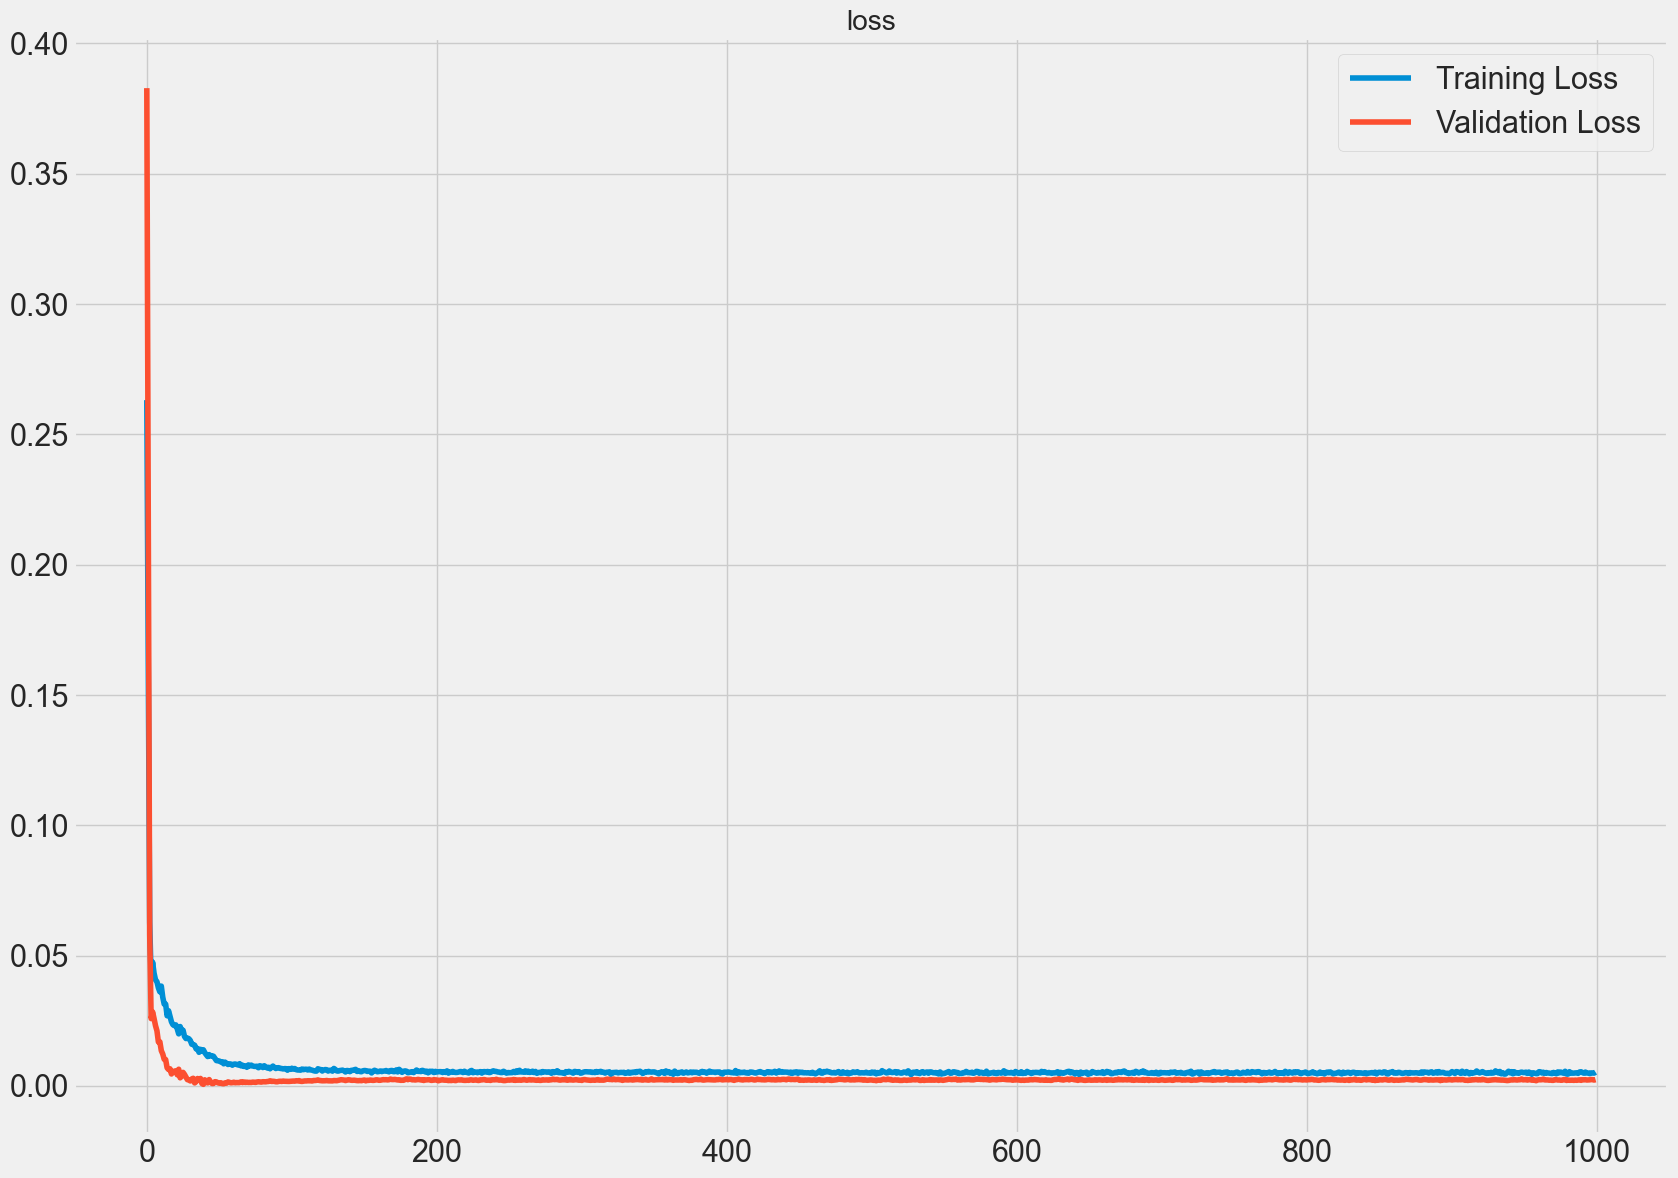

In [330]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title('loss')
plt.legend()
plt.show()

---

### Predicts

In [331]:
y_pred = model_lstm.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 379ms/step


In [332]:
# Rescale the data back to the original scale
y_test = y_test*(train_max[0] - train_min[0]) + train_min[0]
y_pred = y_pred*(train_max[0] - train_min[0]) + train_min[0]
y_train = y_train*(train_max[0] - train_min[0]) + train_min[0]

In [333]:
y_test[:10]
y_train[:10]
print(len(y_train))
print(len(y_test))

1510
59


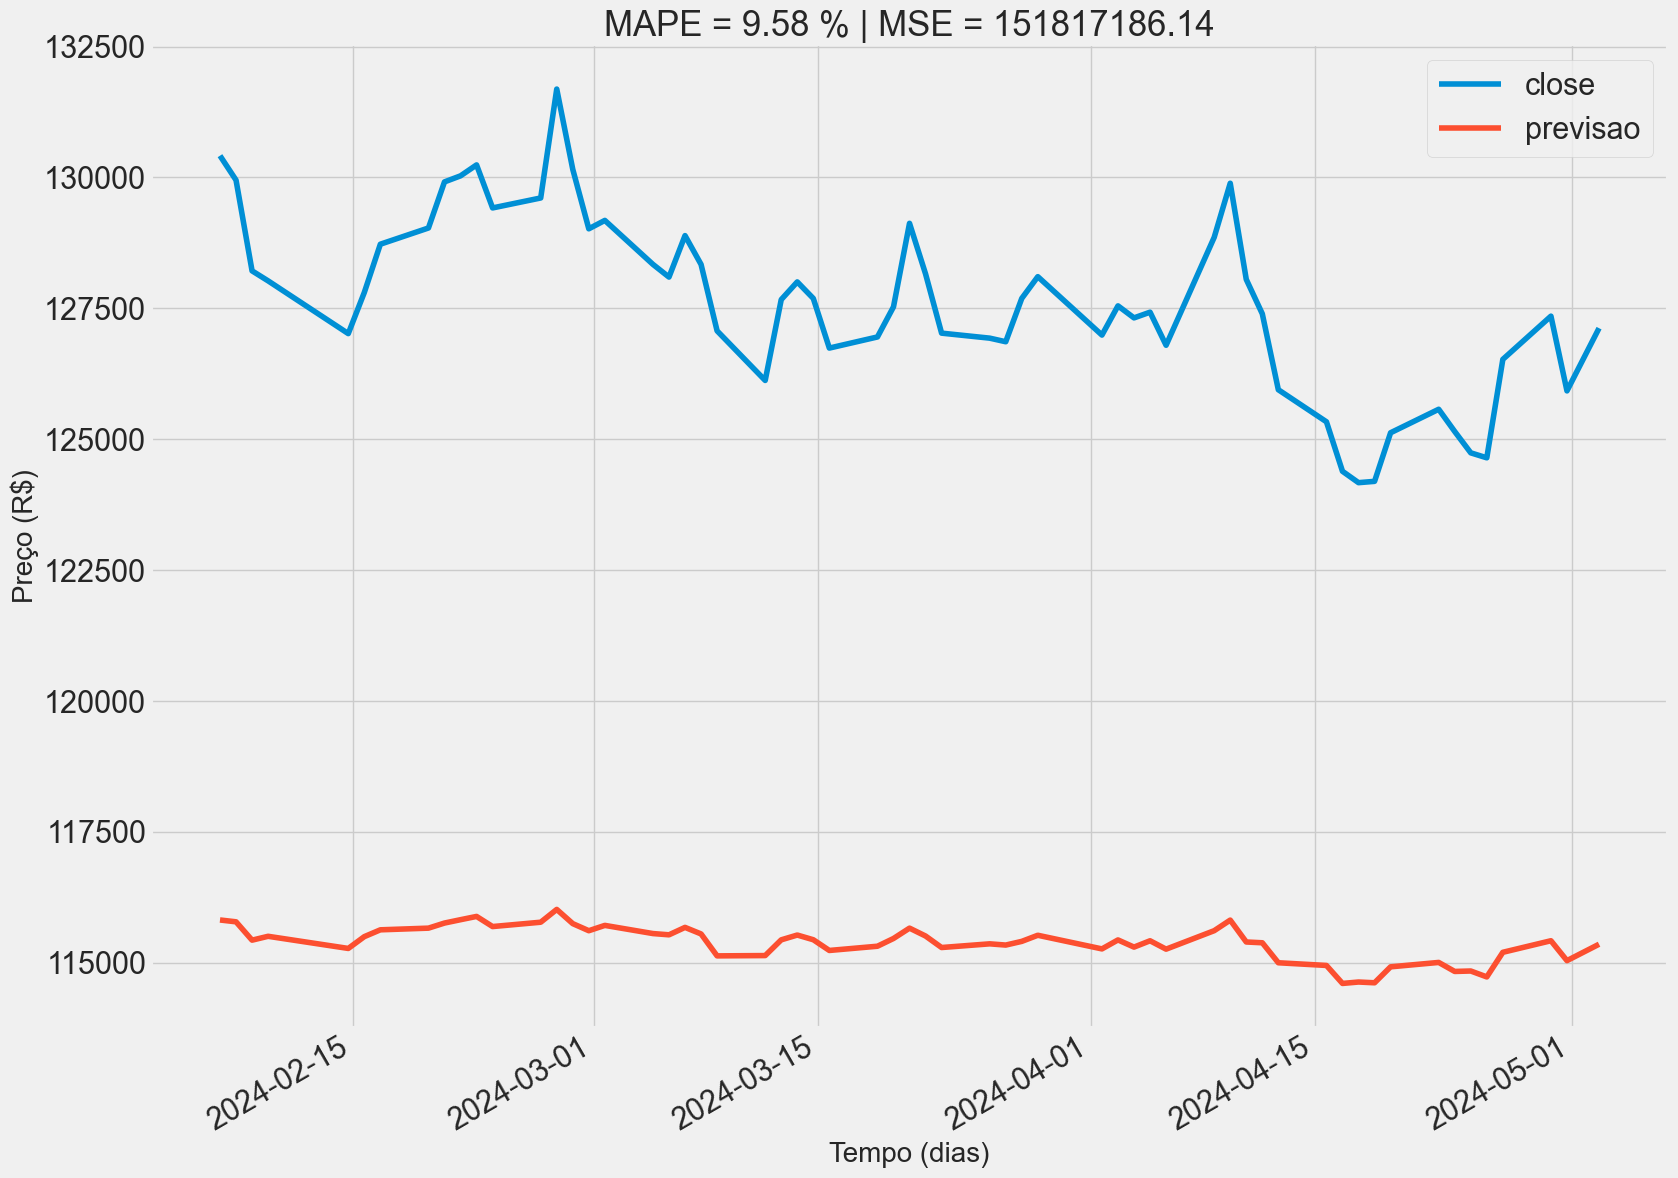

In [334]:
show_result_model(df_test=df_test['close'][:59],
                  y_forecast=y_pred[:59],
                  model_name='model_lstm',
                  dict_results=dict_results)

In [335]:
data = {'test': df_test['close'][:59], 'predict': y_pred.flatten()}
df = pd.DataFrame(data)
df['diff_points'] = df['test'] - df['predict']
df['diff_point_%'] = round((df['diff_points'] / df['test']) * 100, 2)
df.tail()

,test,predict,diff_points,diff_point_%
date,,,,
2024-04-25 16:56:00,124645.58,114730.77,9914.81,7.95
2024-04-26 16:56:00,126526.27,115200.78,11325.49,8.95
2024-04-29 16:56:00,127351.79,115421.73,11930.06,9.37
2024-04-30 16:56:00,125924.19,115041.69,10882.50,8.64
2024-05-02 16:56:00,127122.25,115355.12,11767.12,9.26


---
